In [218]:
import sys
from itertools import combinations
from math import sin
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from tqdm import tqdm

sys.path.append("../code/")

import xgi
from hypersync_draw import *
from hypersync_generate import *
from hypersync_identify import *
from hypersync_integrate import *

sb.set_theme(style="ticks", context="paper")

results_dir = "../results/"
data_dir = "../data/"

Path(results_dir).mkdir(parents=True, exist_ok=True)
Path(data_dir).mkdir(parents=True, exist_ok=True)

In [4]:
from math import cos, pi, sin, exp

In [189]:
N = 84
j = 1
q = np.arange(N)

k1 = 1
k2 = 3

def lambda_j(N, k1, k2):
    
    js = np.arange(N)
    q = np.arange(N)
    lambdas = np.zeros((len(q), len(js)), dtype=np.complex_)

    a1_2 = (k1 / 2) * np.cos(2 * np.pi * q / N)
    a1_3 = (k1 / 2) * np.cos(4 * np.pi * q / N)
    a1_1 = -2 * (a1_2 + a1_3)

    a2_2 = (k2 / 6) * (1 + np.cos(2 * np.pi * q / N) + np.cos(6 * np.pi * q / N))
    a2_3 = (k2 / 6) * (1 + np.cos(2 * np.pi * q / N) + np.cos(6 * np.pi * q / N))
    a2_1 = -2 * (a2_2 + a2_3)

    a_1 = a1_1 + a2_1
    a_2 = a1_2 + a2_2
    a_3 = a1_3 + a2_3

    a = [a1, a2, a3]


    for j in js:
        lambda_j = (
            a_1
            + (a_2 * np.exp(2 * pi * 1j * (j - 1) * (2 - 1) / N))
            + (a_3 * np.exp(2 * pi * 1j * (j - 1) * (3 - 1) / N))
            + (a_2 * np.exp(2 * pi * 1j * (j - 1) * (N - 1) / N))
            + (a_3 * np.exp(2 * pi * 1j * (j - 1) * (N -1 - 1) / N))
        )
        lambdas[:, j] = lambda_j
    
    #print(np.allclose(a_2, (a_2 * np.exp(2 * pi * 1j * (j - 1) * (2 - 1) / N))))
    #print(np.allclose(a_3, (a_3 * np.exp(2 * pi * 1j * (j - 1) * (3 - 1) / N))))

    return lambdas

In [190]:
lamb = lambda_j(N, k1, k2)

In [191]:
np.allclose(np.imag(lamb), 0)

True

In [203]:
L1 = np.sort_complex(lamb, axis=1)[0]
L2 = np.sort_complex(lamb, axis=1)[1]

TypeError: _sort_complex() got an unexpected keyword argument 'axis'

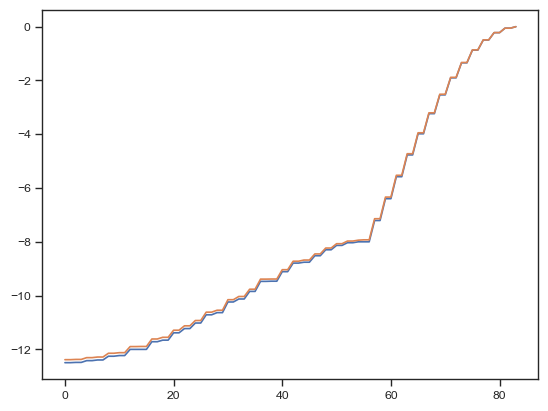

In [202]:
plt.plot(L1)
plt.plot(L2)

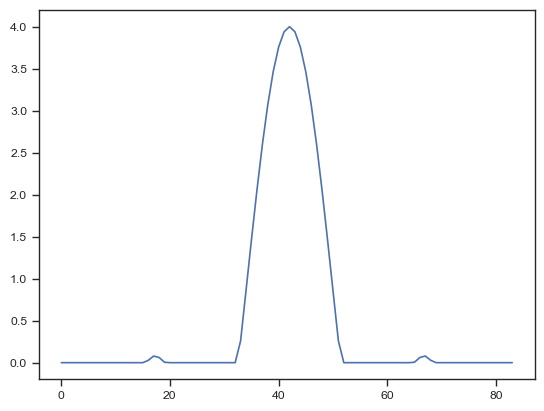

In [192]:
plt.plot(np.max(lamb, axis=1))

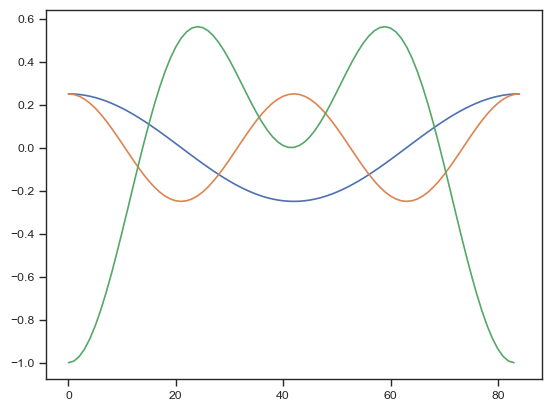

In [103]:
plt.plot((k1 / 4) * np.cos(2 * np.pi * q / N))
plt.plot((k1 / 4) * np.cos(4 * np.pi * q / N))
plt.plot(-2 * (a1_2 + a1_3))

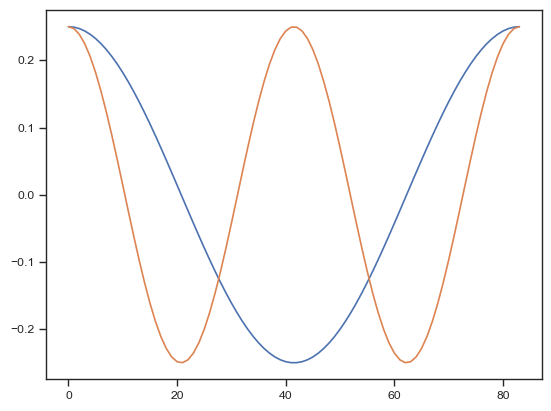

In [135]:
a2 = (k1 / 4) * np.cos(2 * np.pi * q / N)
a3 = (k1 / 4) * np.cos(4 * np.pi * q / N)
j = 1

plt.plot(a_2 * np.exp(2 * pi * 1j * (j - 1) * (2 - 1) / N))
plt.plot(a_3 * np.exp(2 * pi * 1j * (j - 1) * (3 - 1) / N))

## Yuanzhao's

In [407]:
from math import cos, sin
from numba import jit

In [412]:
# Directed hypergraphs
@jit 
def lambda2(N, K1, K2, q, r):
    a2 = K1 * cos(2 * np.pi * q / N) / r
    a3 = K1 * cos(4 * np.pi * q / N) / r
    a1 = -2 * (a2 + a3)

    b2 = K2 * (1 + cos(2 * np.pi * q / N) + cos(6 * np.pi * q / N)) / (r * (2 * r - 1))
    b3 = K2 * (1 + cos(2 * np.pi * q / N) + cos(6 * np.pi * q / N)) / (r * (2 * r - 1))
    b1 = -2 * (b2 + b3)

    A1 = a1 + b1
    A2 = a2 + b2
    A3 = a3 + b3

    Lambda = np.zeros(N, dtype=np.complex_)
    for i in range(N):
        Lambda[i] = (
            A1
            + A2 * np.exp(2j * np.pi * i / N)
            + A3 * np.exp(2j * np.pi * i * 2 / N)
            + A2 * np.exp(2j * np.pi * i * (N - 1) / N)
            + A3 * np.exp(2j * np.pi * i * (N - 2) / N)
        )

    Lambda = np.real(Lambda)
    lambda_2 = np.sort(Lambda[1:])[-1]

    return lambda_2

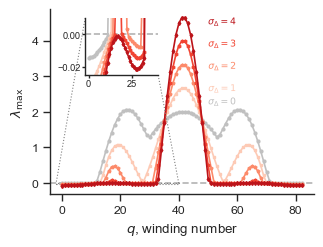

In [377]:
m = 5
N = 83
r = 2
r1 = 1
r2 = range(m)
Lambda_2 = np.zeros((N, m), dtype=np.complex_)

for q in range(N):
    for j in range(m):
        Lambda_2[q, j] = lambda2(N, r1, r2[j], q, r)

fig, ax = plt.subplots(figsize=(3.4, 2.4))

ax.set_xlabel(r"$q$, winding number")
ax.set_ylabel(r"$\lambda_\mathrm{max}$")

markers = ["o", "s", "p", "h", "d"]
labels = [
    r"$\sigma_\Delta=0$",
    r"$\sigma_\Delta=1$",
    r"$\sigma_\Delta=2$",
    r"$\sigma_\Delta=3$",
    r"$\sigma_\Delta=4$",
]

colors = ["silver"] + sb.color_palette("Reds", n_colors=len(labels) - 1)

for i in range(m):
    ax.plot(
        Lambda_2.real[:, i],
        linestyle="-",
        # linewidth=3,
        marker=markers[i],
        ms=2,
        color=colors[i],
        # alpha=0.6,
        label=labels[i],
    )

ax.axhline(0, linestyle="--", alpha=0.6, c="grey", zorder=-2)


from labellines import labelLine, labelLines

legs = labelLines(
    ax.get_lines(),
    zorder=2.5,
    xvals=[40] * 5,
    yoffsets=[0.3] + [0.05] * 5,
    fontsize="x-small",
    align=False,
)
x_offset = 15
for leg in legs:
    x, y = leg.get_position()
    leg.set_position((x + x_offset, y))
    
    
    

# insets
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

axins1 = inset_axes(
    ax,
    width="100%", height="100%",
    bbox_to_anchor=(10, 3.2, 25, 1.6),
    bbox_transform=ax.transData,
)

for i in range(m):
    axins1.plot(
        Lambda_2.real[:, i],
        linestyle="-",
        # linewidth=3,
        marker=markers[i],
        ms=2,
        color=colors[i],
        # alpha=0.6,
        label=labels[i],
    )
    
axins1.set_ylim([-0.025, 0.01])
axins1.set_xlim([-2, 40])
axins1.axhline(0, linestyle="--", alpha=0.6, c="grey", zorder=-2)

axins1.set_ylabel("")
plt.yticks(fontsize="x-small")
#axins1.set_xticks([])
plt.xticks(fontsize="x-small")
#plt.xlabel(fontsize="x-small", labelpad=3)
axins1.tick_params('both', length=2, which='major', pad=1)

mark_inset(ax, axins1, loc1=2, loc2=4, ec="0.5", ls=":")



sb.despine()

# plt.savefig("lambda2.pdf")

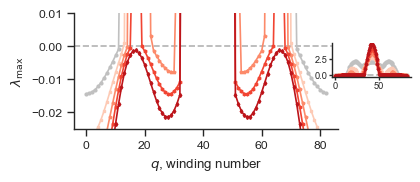

In [373]:
m = 5
N = 83
r = 2
r1 = 1
r2 = range(m)
Lambda_2 = np.zeros((N, m), dtype=np.complex_)

for q in range(N):
    for j in range(m):
        Lambda_2[q, j] = lambda2(N, r1, r2[j], q, r)

fig, ax = plt.subplots(figsize=(3.4, 1.5))

ax.set_xlabel(r"$q$, winding number")
ax.set_ylabel(r"$\lambda_\mathrm{max}$")

markers = ["o", "s", "p", "h", "d"]
labels = [
    r"$\sigma_\Delta=0$",
    r"$\sigma_\Delta=1$",
    r"$\sigma_\Delta=2$",
    r"$\sigma_\Delta=3$",
    r"$\sigma_\Delta=4$",
]

colors = ["silver"] + sb.color_palette("Reds", n_colors=len(labels) - 1)

for i in range(m):
    ax.plot(
        Lambda_2.real[:, i],
        linestyle="-",
        # linewidth=3,
        marker=markers[i],
        ms=2,
        color=colors[i],
        # alpha=0.6,
        label=labels[i],
    )

ax.axhline(0, linestyle="--", alpha=0.6, c="grey", zorder=-2)


from labellines import labelLine, labelLines

legs = labelLines(
    ax.get_lines(),
    zorder=2.5,
    xvals=[40] * 5,
    yoffsets=[0.3] + [0.05] * 5,
    fontsize="x-small",
    align=False,
)
x_offset = 15
for leg in legs:
    x, y = leg.get_position()
    leg.set_position((x + x_offset, y))
    
    
    

# insets
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

axins1 = inset_axes(
    ax,
    width="100%", height="100%",
    bbox_to_anchor=(1, 0.5, 0.3, 0.3),
    bbox_transform=ax.transAxes,
)

for i in range(m):
    axins1.plot(
        Lambda_2.real[:, i],
        linestyle="-",
        # linewidth=3,
        marker=markers[i],
        ms=2,
        color=colors[i],
        # alpha=0.6,
        label=labels[i],
    )
    
#axins1.set_ylim([-0.025, 0.01])
#axins1.set_xlim(xmax=40)
axins1.axhline(0, linestyle="--", alpha=0.6, c="grey", zorder=-2)

axins1.set_ylabel("")
plt.yticks(fontsize="x-small")
#axins1.set_xticks([])
plt.xticks(fontsize="x-small")
#plt.xlabel(fontsize="x-small", labelpad=3)
axins1.tick_params('both', length=2, which='major', pad=1)

#mark_inset(ax, axins1, loc1=2, loc2=4, ec="0.5", ls=":")

ax.set_ylim([-0.025, 0.01])


sb.despine()

# plt.savefig("lambda2.pdf")

In [413]:
m = 50
N1 = 83
N2 = 830
r = 2
r1 = 1
r2 = np.linspace(0, 4, num=m)

Lambda_2 = np.zeros((N1, m), dtype=np.complex_)
for q in range(N1):
    for j in range(m):
        Lambda_2[q, j] = lambda2(N1, r1, r2[j], q, r)
stable_fraction1 = np.mean(Lambda_2 < 0, axis=0)

Lambda_2 = np.zeros((N2, m), dtype=np.complex_)
for q in range(N2):
    for j in range(m):
        Lambda_2[q, j] = lambda2(N2, r1, r2[j], q, r)
stable_fraction2 = np.mean(Lambda_2 < 0, axis=0)


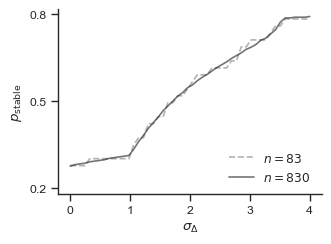

In [414]:


fig, ax = plt.subplots(figsize=(3.4, 2.4))

ax.set_xlabel(r"$\sigma_\Delta$")
ax.set_ylabel(r"$p_\mathrm{stable}$")


ax.plot(
    r2,
    stable_fraction1,
    linestyle="--",
    color="grey",
    alpha=0.6,
    label=r"$n=83$",
)
ax.plot(
    r2,
    stable_fraction2,
    linestyle="-",
    color="k",
    alpha=0.6,
    label=r"$n=830$",
)

#ax.set_xticks([0, 2, 4])
ax.set_yticks([0.2, 0.5, 0.8])
ax.set_ylim(ymin=0.18)


ax.legend(loc="lower right", frameon=False, ncol=1)

sb.despine()


#plt.savefig("stable_fraction.pdf")

## all together

/Users/maxime/.pyenv/versions/venv_xgi/lib/python3.9/site-packages/labellines/core.py:148: UserWarning: Tried to label line Line2D(_child5), but could not find a label for it.
  warnings.warn(


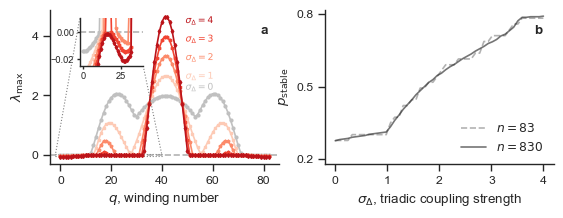

In [430]:
m = 5
N = 83
r = 2
r1 = 1
r2 = range(m)
Lambda_2 = np.zeros((N, m), dtype=np.complex_)

for q in range(N):
    for j in range(m):
        Lambda_2[q, j] = lambda2(N, r1, r2[j], q, r)

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(6.5, 2))

ax.set_xlabel(r"$q$, winding number")
ax.set_ylabel(r"$\lambda_\mathrm{max}$")

markers = ["o", "s", "p", "h", "d"]
labels = [
    r"$\sigma_\Delta=0$",
    r"$\sigma_\Delta=1$",
    r"$\sigma_\Delta=2$",
    r"$\sigma_\Delta=3$",
    r"$\sigma_\Delta=4$",
]

colors = ["silver"] + sb.color_palette("Reds", n_colors=len(labels) - 1)

for i in range(m):
    ax.plot(
        Lambda_2.real[:, i],
        linestyle="-",
        # linewidth=3,
        marker=markers[i],
        ms=2,
        color=colors[i],
        # alpha=0.6,
        label=labels[i],
    )

ax.axhline(0, linestyle="--", alpha=0.6, c="grey", zorder=-2)
ax.set_yticks([0, 2, 4])

from labellines import labelLine, labelLines

legs = labelLines(
    ax.get_lines(),
    zorder=2.5,
    xvals=[40] * 5,
    yoffsets=[0.3] + [0.05] * 5,
    fontsize="x-small",
    align=False,
)
x_offset = 15
for leg in legs:
    x, y = leg.get_position()
    leg.set_position((x + x_offset, y))
    
    
    

# insets
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

axins1 = inset_axes(
    ax,
    width="100%", height="100%",
    bbox_to_anchor=(10, 3.2, 25, 1.6),
    bbox_transform=ax.transData,
)

for i in range(m):
    axins1.plot(
        Lambda_2.real[:, i],
        linestyle="-",
        # linewidth=3,
        marker=markers[i],
        ms=2,
        color=colors[i],
        # alpha=0.6,
        label=labels[i],
    )
    
axins1.set_ylim([-0.025, 0.01])
axins1.set_xlim([-2, 40])
axins1.axhline(0, linestyle="--", alpha=0.6, c="grey", zorder=-2)

axins1.set_ylabel("")
plt.yticks([0, -0.02], fontsize="x-small")
#axins1.set_xticks([])
plt.xticks(fontsize="x-small")
#plt.xlabel(fontsize="x-small", labelpad=3)
axins1.tick_params('both', length=2, which='major', pad=2)

mark_inset(ax, axins1, loc1=2, loc2=4, ec="0.5", ls=":")



sb.despine()

#######
# other one
##########

m = 50
N1 = 83
N2 = 830
r = 2
r1 = 1
r2 = np.linspace(0, 4, num=m)

Lambda_2 = np.zeros((N1, m), dtype=np.complex_)
for q in range(N1):
    for j in range(m):
        Lambda_2[q, j] = lambda2(N1, r1, r2[j], q, r)
stable_fraction1 = np.mean(Lambda_2 < 0, axis=0)

Lambda_2 = np.zeros((N2, m), dtype=np.complex_)
for q in range(N2):
    for j in range(m):
        Lambda_2[q, j] = lambda2(N2, r1, r2[j], q, r)
stable_fraction2 = np.mean(Lambda_2 < 0, axis=0)


ax2.set_xlabel(r"$\sigma_\Delta$, triadic coupling strength")
ax2.set_ylabel(r"$p_\mathrm{stable}$")


ax2.plot(
    r2,
    stable_fraction1,
    linestyle="--",
    color="grey",
    alpha=0.6,
    label=r"$n=83$",
)
ax2.plot(
    r2,
    stable_fraction2,
    linestyle="-",
    color="k",
    alpha=0.6,
    label=r"$n=830$",
)

#ax.set_xticks([0, 2, 4])
ax2.set_yticks([0.2, 0.5, 0.8])
ax2.set_ylim(ymin=0.18)


ax2.legend(loc="lower right", frameon=False, ncol=1)

ax.text(0.95, 0.9, "a", transform=ax.transAxes, weight="bold", va="top", ha="right")
ax2.text(0.95, 0.9, "b", transform=ax2.transAxes, weight="bold", va="top", ha="right")

sb.despine()


plt.savefig("../results/figure_1.pdf", dpi=250, bbox_inches="tight", pad_inches=0)

In [ ]:
fig, axs = plt.subplots(1, 3)

N = 10

for q in range(3)
    psi = generate_q_twisted_state(N, q)
    plot_phases